In [2]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from glob import glob
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

2.4.1


In [4]:
tr_inf = glob('Dataset/Train/Parasite/*')
tr_he = glob('Dataset/Train/Uninfected/*')

In [5]:
infected_trn_samples = random.sample(tr_inf, 10)
healthy_trn_samples = random.sample(tr_he, 10)

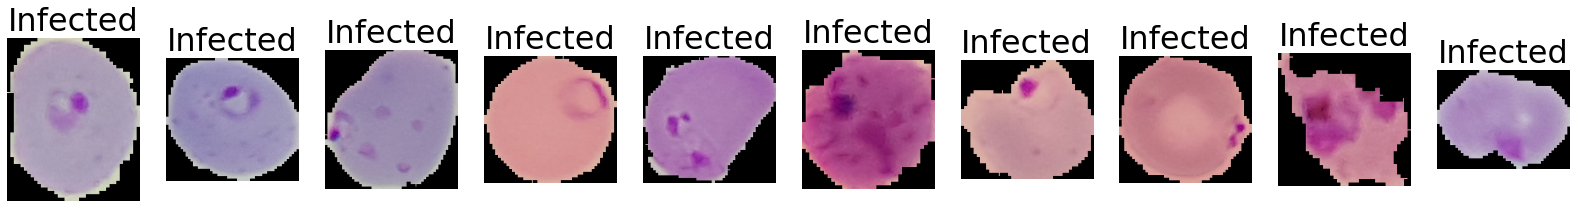

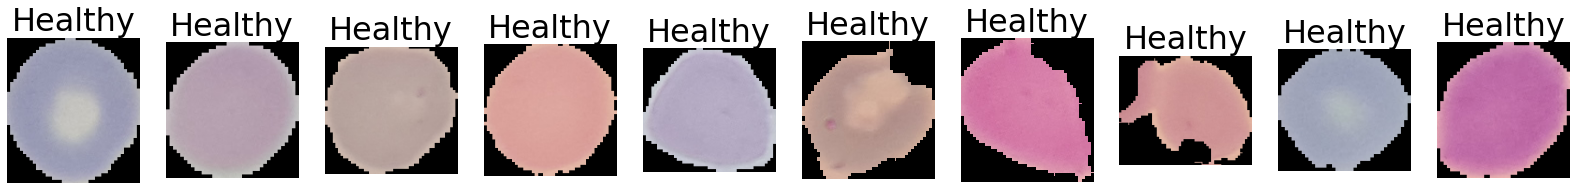

In [6]:
fig =plt.figure(figsize=(28,14))
columns=10
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(infected_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Infected', fontsize=32)
plt.show()


fig =plt.figure(figsize=(28,14))
columns=10
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(healthy_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Healthy', fontsize=32)
plt.show()

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255.)

In [18]:
train_generator = train_datagen.flow_from_directory('Dataset/Train',
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

Found 27558 images belonging to 2 classes.


In [19]:
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False, 
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False
    
x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [20]:
model_01.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [21]:
test_generator = test_datagen.flow_from_directory('Dataset/Test',
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 134 images belonging to 2 classes.


In [37]:
history_01 = model_01.fit_generator(train_generator,
                                 steps_per_epoch=50,
                                 epochs=50,
                                 validation_steps = len(test_generator))

C:\Users\shiva\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 119s 2s/step - loss: 0.3628 - accuracy: 0.8425
Epoch 2/50
50/50 [==============================] - 133s 3s/step - loss: 0.3950 - accuracy: 0.8244
Epoch 3/50
50/50 [==============================] - 142s 3s/step - loss: 0.3521 - accuracy: 0.8475
Epoch 4/50
50/50 [==============================] - 162s 3s/step - loss: 0.3594 - accuracy: 0.8481
Epoch 5/50
50/50 [==============================] - 192s 4s/step - loss: 0.3667 - accuracy: 0.8363
Epoch 6/50
50/50 [==============================] - 167s 3s/step - loss: 0.3715 - accuracy: 0.8463
Epoch 7/50
50/50 [==============================] - 146s 3s/step - loss: 0.3823 - accuracy: 0.8256
Epoch 8/50
50/50 [==============================] - 146s 3s/step - loss: 0.3757 - accuracy: 0.8369
Epoch 9/50
50/50 [==============================] - 141s 3s/step - loss: 0.3783 - accuracy: 0.8316
Epoch 10/50
50/50 [==============================] - 143s 3s/step - loss: 0.4043 - accuracy: 0.8194
Epoch 11/

KeyboardInterrupt: 

In [38]:
from tensorflow.keras.models import load_model

model_01.save('malaria_model111.h5')

In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [40]:

filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict_generator(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

C:\Users\shiva\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


134/134 [==============================] - 13s 99ms/step


In [41]:
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])

              precision    recall  f1-score   support

     healthy       0.99      0.82      0.90        91
    infected       0.72      0.98      0.83        43

    accuracy                           0.87       134
   macro avg       0.86      0.90      0.86       134
weighted avg       0.90      0.87      0.88       134



In [42]:
te_inf = glob('C:/Users/shiva/Documents/Project/Malaria-Detection-master/Dataset/Test/Parasite/*')
te_he = glob('C:/Users/shiva/Documents/Project/Malaria-Detection-master/Dataset/Test/Uninfected/*')

In [47]:
test_images = [img for img in random.sample(te_inf, 15)]
test_images.extend([img for img in random.sample(te_he, 15)])

In [48]:
class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

In [49]:
class_labels, class_names

({'Parasite': 0, 'Uninfected': 1}, {0: 'Parasite', 1: 'Uninfected'})

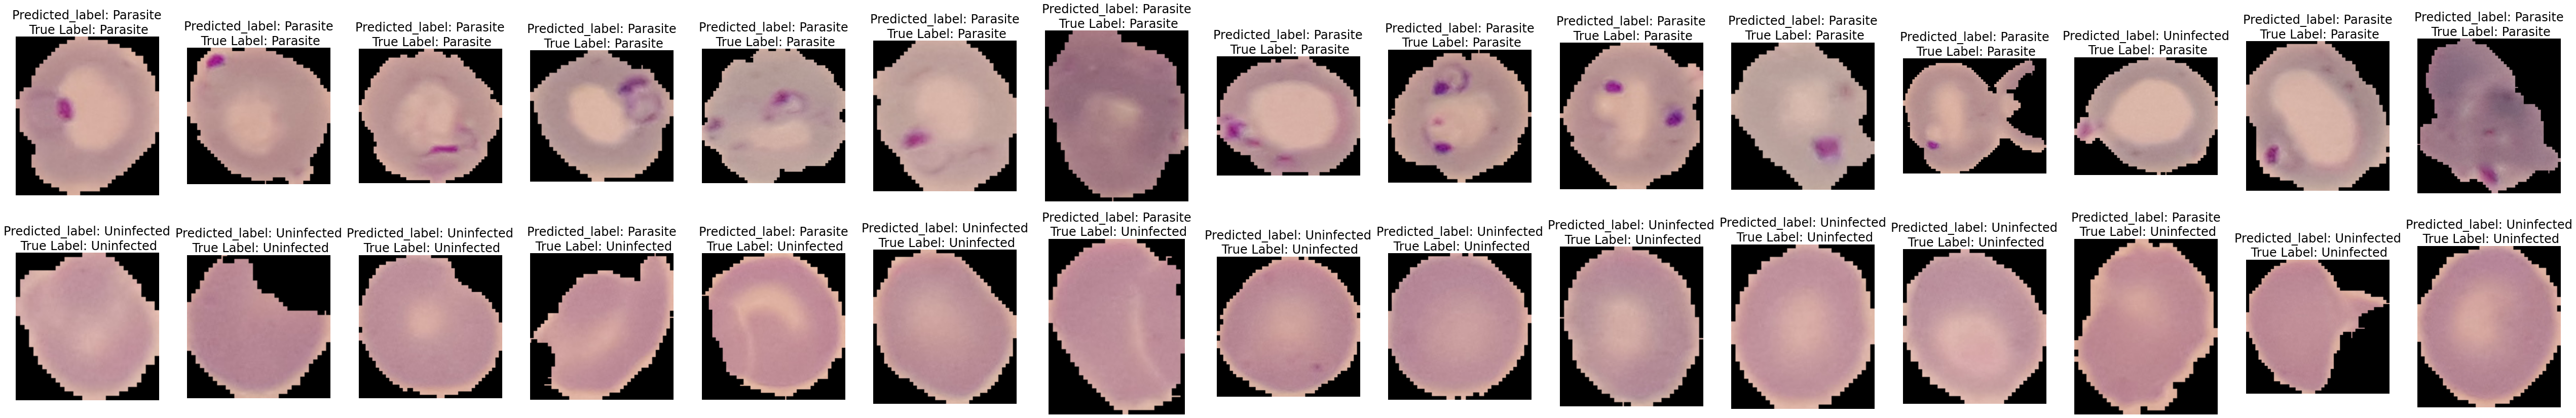

In [51]:
true_labels = []
predicted_labels = [] 
fig = plt.figure(figsize=(90,14))
columns=15
rows=2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('\\')[0].split('/')[8])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img)
    plt.axis('off')
    img = image.load_img(test_images[i-1], target_size=(128,128))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_01.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=24)
plt.show()